# Results for PCA+LSTM



In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model, stocks_numbers
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_gru/'
if_should_savefig = False # TODO

In [3]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    d = pd.read_csv(os.path.join(data_dir, f))
    d['filename'] = [f for i in range(len(d))]
    number_of_units = []
    for i, row in d.iterrows():
        unit = row['unit'].split(':')[0][1:]
        number_of_units.append(unit)
    d['number_of_units'] = number_of_units
    df_res = df_res.append(d)
df_res['diff'] = df_res['train_matthews'] - df_res['matthews']
df_log = pd.read_csv('res_log_que.csv')    
columns = ['matthews', 'test_matthews', 'stock', 'unit']
df_best = df_res.sort_values(by='matthews', ascending=False).groupby(['stock']).head(1)
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['_lstm', '_log'])
df_best.index = df_best['stock']

In [4]:
df_best[['r', 's', 'unit', 'n_steps', 'kernel_reg', 'train_matthews_lstm',
         'matthews_lstm', 'test_matthews_lstm', 'test_matthews_log', 'stock', 'filename']]

,r,s,unit,n_steps,kernel_reg,train_matthews_lstm,matthews_lstm,test_matthews_lstm,test_matthews_log,stock,filename
stock,,,,,,,,,,,
2748,0.01,0.10,"(32: tanh, 1)",16,0.0000,0.265068,0.200579,0.146445,0.134270,2748,res_gru_pca_n_one_layer_step16_2748_len24000_r...
3879,0.01,0.10,"(32: tanh, 1)",4,0.0010,0.155667,0.158942,0.120586,0.120553,3879,res_gru_pca_n_one_layer_step4_3879_len24000_r0...
9761,0.01,0.10,"(8: tanh, 1)",16,0.0000,0.153762,0.158637,0.111831,0.107514,9761,res_gru_pca_n_one_layer_step16_9761_len24000_r...
4851,0.01,0.10,"(32: tanh, 1)",16,0.0010,0.178745,0.155013,0.164520,0.138680,4851,res_gru_pca_n_one_layer_step16_4851_len24000_r...
10470,0.01,0.10,"(32: tanh, 1)",1,0.0001,0.132563,0.150017,0.137040,0.126946,10470,res_gru_pca_n_one_layer_10470_len24000_r0.01_s...
4320,0.10,0.10,"(32: tanh, 1)",16,0.0010,0.165089,0.149794,0.137224,0.133149,4320,res_gru_pca_n_one_layer_step16_4320_len24000_r...
2730,0.25,0.25,"(32: tanh, 1)",4,0.0000,0.148255,0.142332,0.166390,0.150420,2730,res_gru_pca_n_one_layer_step4_2730_len24000_r0...
4799,0.25,0.25,"(32: tanh, 1)",8,0.0100,0.135924,0.137183,0.133901,0.124435,4799,res_gru_pca_n_one_layer_step8_4799_len24000_r0...
1431,0.25,0.25,"(16: tanh, 1)",16,0.0000,0.135917,0.136941,0.123672,0.123012,1431,res_gru_pca_n_one_layer_step16_1431_len24000_r...


In [5]:
df_res.sort_values(by='test_matthews', ascending=False).groupby(
    'stock').head(1)[['matthews', 'stock', 'test_matthews', 'r', 's', 'number_of_units', 'kernel_reg']]

,matthews,stock,test_matthews,r,s,number_of_units,kernel_reg
2,0.137715,4851,0.186746,0.25,0.25,32,0.000
2,0.137577,2730,0.170750,0.25,0.25,32,0.000
5,0.113868,3459,0.167582,0.10,0.10,32,0.001
0,0.191703,2748,0.166775,0.10,0.10,8,0.000
2,0.143386,4320,0.150145,0.10,0.50,32,0.000
1,0.126842,2822,0.149265,0.25,0.25,16,0.000
2,0.142014,3879,0.147911,0.10,0.50,32,0.000
1,0.136407,10470,0.144944,0.01,0.10,16,0.000
9,0.110865,4799,0.140233,0.25,0.25,4,0.001
3,0.126057,1431,0.135608,0.01,0.10,8,0.001


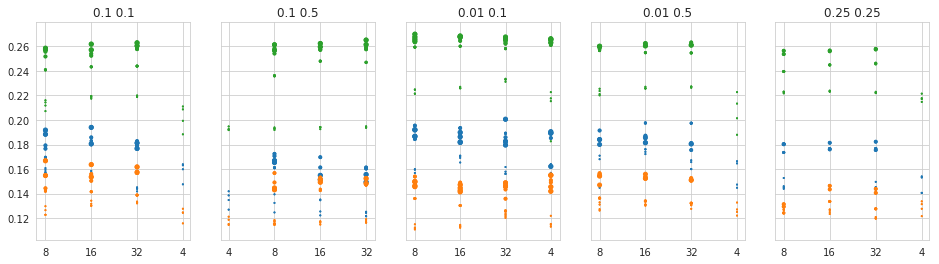

In [27]:
fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=True)
i = 0
for r, s in stocks_numbers.rs_params:
    d = df_res[df_res['r'] == r] 
    d = d[d['s'] == s]
    d = d[d['stock'] == 2748]
  # ax[i].axhline(d['test_matthews_log'].values[0])
    ax[i].scatter(d['number_of_units'], d['matthews'], d['n_steps'])
    ax[i].scatter(d['number_of_units'], d['test_matthews'], d['n_steps'])
    ax[i].scatter(d['number_of_units'], d['train_matthews'], d['n_steps'])

    ax[i].set_title(f'{r} {s}')
    i += 1

In [28]:
df_best[['r', 's', 'train_roc_auc_lstm',
         'roc_auc_lstm', 'test_roc_auc_lstm', 'test_roc_auc_log', 'stock', 'filename']]

,r,s,train_roc_auc_lstm,roc_auc_lstm,test_roc_auc_lstm,test_roc_auc_log,stock,filename
stock,,,,,,,,
2748,0.01,0.10,0.676904,0.620273,0.602292,0.596587,2748,res_gru_pca_n_one_layer_step16_2748_len24000_r...
3879,0.01,0.10,0.586071,0.588576,0.565639,0.565858,3879,res_gru_pca_n_one_layer_step4_3879_len24000_r0...
9761,0.01,0.10,0.584015,0.582593,0.560776,0.558467,9761,res_gru_pca_n_one_layer_step16_9761_len24000_r...
4851,0.01,0.10,0.621725,0.610910,0.617953,0.600747,4851,res_gru_pca_n_one_layer_step16_4851_len24000_r...
10470,0.01,0.10,0.576241,0.585441,0.577046,0.571430,10470,res_gru_pca_n_one_layer_10470_len24000_r0.01_s...
4320,0.10,0.10,0.588751,0.581109,0.571216,0.572081,4320,res_gru_pca_n_one_layer_step16_4320_len24000_r...
2730,0.25,0.25,0.587132,0.582909,0.595637,0.586607,2730,res_gru_pca_n_one_layer_step4_2730_len24000_r0...
4799,0.25,0.25,0.575963,0.577476,0.575352,0.570149,4799,res_gru_pca_n_one_layer_step8_4799_len24000_r0...
1431,0.25,0.25,0.575800,0.574763,0.567309,0.567606,1431,res_gru_pca_n_one_layer_step16_1431_len24000_r...


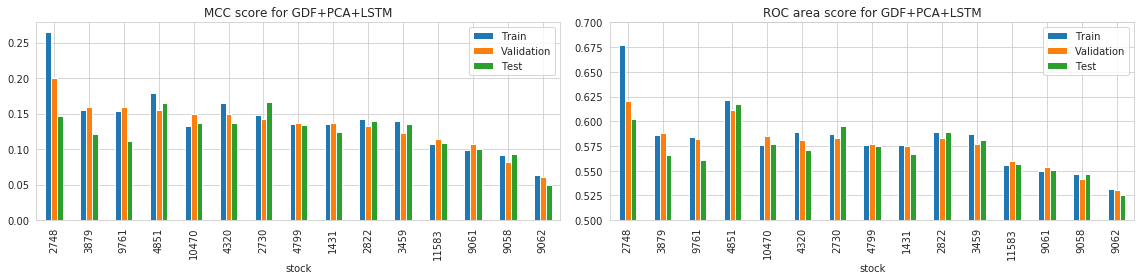

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best[['train_matthews_lstm', 'matthews_lstm', 'test_matthews_lstm']].plot(kind='bar', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])
ax1.set_title('MCC score for GDF+PCA+LSTM')

df_best[['train_roc_auc_lstm', 'roc_auc_lstm', 'test_roc_auc_lstm']].plot(kind='bar', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])
ax2.set_ylim(0.5, 0.7)
ax2.set_title('ROC area score for GDF+PCA+LSTM')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_mcc_roc_scores_bar.png')

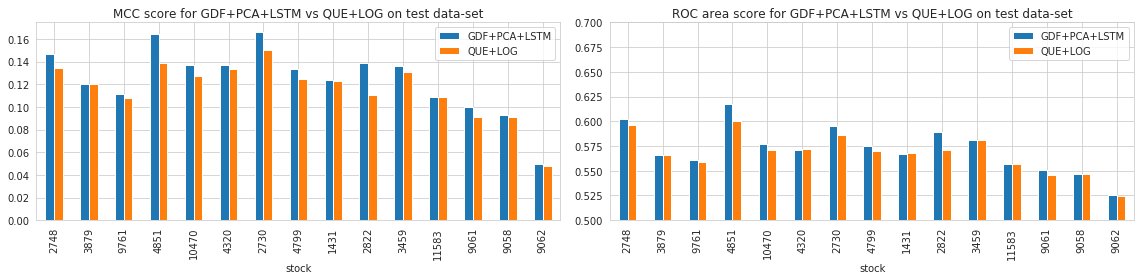

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best[['test_matthews_lstm', 'test_matthews_log']].plot(kind='bar', ax=ax1)
ax1.legend(['GDF+PCA+LSTM', 'QUE+LOG'])
ax1.set_title('MCC score for GDF+PCA+LSTM vs QUE+LOG on test data-set')

df_best[['test_roc_auc_lstm', 'test_roc_auc_log']].plot(kind='bar', ax=ax2)
ax2.legend(['GDF+PCA+LSTM', 'QUE+LOG'])
ax2.set_ylim(0.5, 0.7)
ax2.set_title('ROC area score for GDF+PCA+LSTM vs QUE+LOG on test data-set')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_que_log_mcc_roc_scores_bar.png')

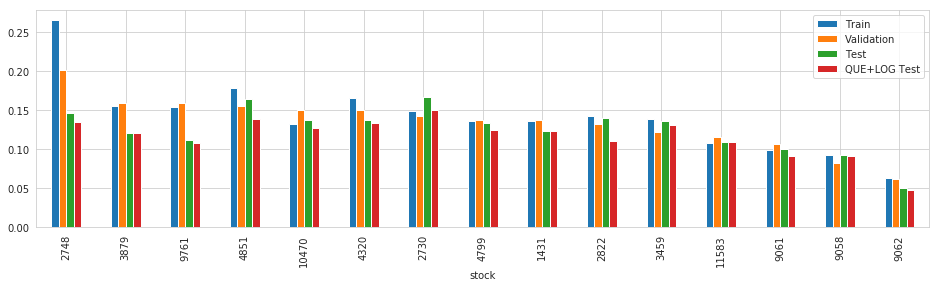

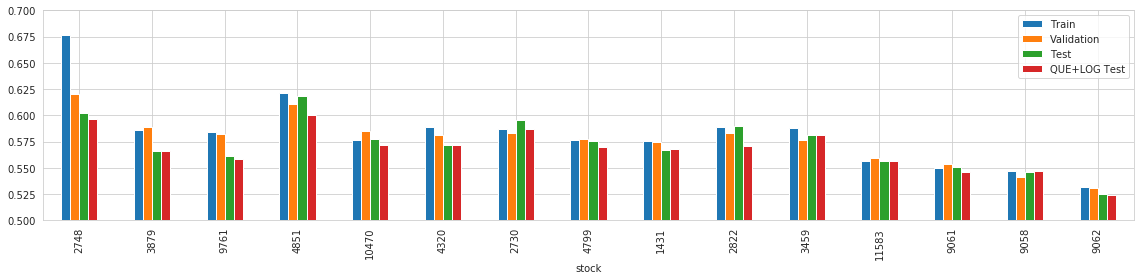

In [31]:
df_best[['train_matthews_lstm', 'matthews_lstm', 'test_matthews_lstm', 'test_matthews_log']].plot(kind='bar', figsize=(16, 4))
plt.legend(['Train', 'Validation', 'Test', 'QUE+LOG Test'])

df_best[['train_roc_auc_lstm', 'roc_auc_lstm', 'test_roc_auc_lstm', 'test_roc_auc_log']].plot(kind='bar', figsize=(16, 4))
plt.legend(['Train', 'Validation', 'Test', 'QUE+LOG Test'])
plt.ylim(0.5, 0.7)
plt.tight_layout()

In [32]:
print(df_best[['train_matthews_lstm', 'matthews_lstm', 'test_matthews_lstm', 
        'train_roc_auc_lstm', 'roc_auc_lstm', 'test_roc_auc_lstm']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  train\_matthews\_lstm &  matthews\_lstm &  test\_matthews\_lstm &  train\_roc\_auc\_lstm &  roc\_auc\_lstm &  test\_roc\_auc\_lstm \\
\midrule
count &            15.000000 &      15.000000 &           15.000000 &           15.000000 &     15.000000 &          15.000000 \\
mean  &             0.140970 &       0.133902 &            0.124522 &            0.582269 &      0.576587 &           0.572123 \\
std   &             0.045715 &       0.033736 &            0.029557 &            0.034132 &      0.023341 &           0.023543 \\
min   &             0.063122 &       0.061404 &            0.049816 &            0.531722 &      0.530545 &           0.525058 \\
25\%   &             0.120158 &       0.118602 &            0.110348 &            0.565937 &      0.567216 &           0.558731 \\
50\%   &             0.139009 &       0.137183 &            0.133901 &            0.584015 &      0.581109 &           0.571216 \\
75\%   &             0.154714 &    

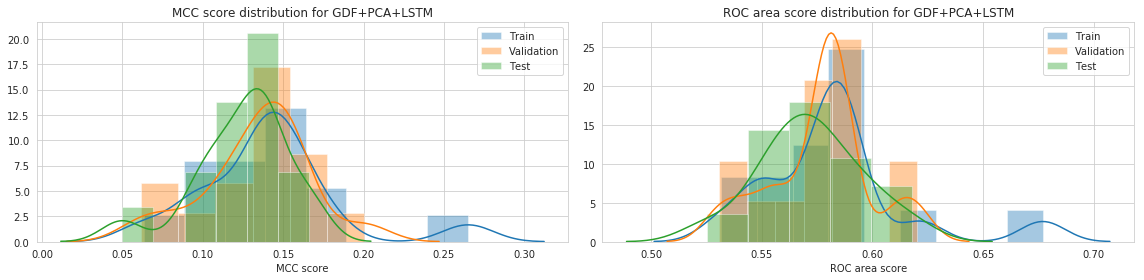

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_best['train_matthews_lstm'], label='Train', ax=ax1)
sns.distplot(df_best['matthews_lstm'], label='Validation', ax=ax1)
sns.distplot(df_best['test_matthews_lstm'], label='Test', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])
ax1.set_title('MCC score distribution for GDF+PCA+LSTM')
ax1.set_xlabel('MCC score')

sns.distplot(df_best['train_roc_auc_lstm'], label='Train', ax=ax2)
sns.distplot(df_best['roc_auc_lstm'], label='Validation', ax=ax2)
sns.distplot(df_best['test_roc_auc_lstm'], label='Test', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])
ax2.set_title('ROC area score distribution for GDF+PCA+LSTM')
ax2.set_xlabel('ROC area score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_score_dist.png')

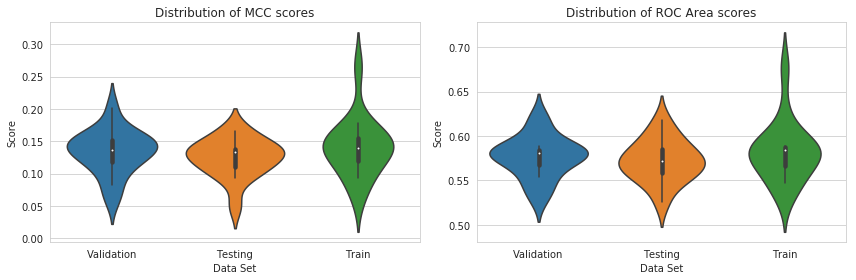

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'matthews_lstm', 'roc_auc_lstm', 
           'test_matthews_lstm', 'test_roc_auc_lstm', 'train_matthews_lstm', 'train_roc_auc_lstm']

df = df_best[columns].copy()
df.rename(columns={
    'matthews_lstm': 'Validation', 'test_matthews_lstm': 'Testing', 'train_matthews_lstm': 'Train'}, inplace=True)
df = df.melt(['stock', 'roc_auc_lstm', 'test_roc_auc_lstm', 'train_roc_auc_lstm'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(columns={'roc_auc_lstm': 'Validation', 'test_roc_auc_lstm': 'Testing', 'train_roc_auc_lstm': 'Train'}, inplace=True)
df = df.melt(['stock', 'matthews_lstm', 'test_matthews_lstm', 'train_matthews_lstm'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('violin_distribution_scores_gdf_pca_lstm.png')

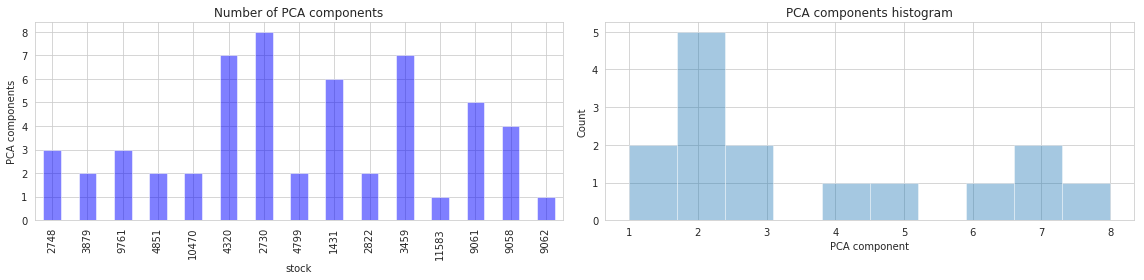

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best['pca_components'].plot(kind='bar', color=['b'], alpha=0.5, ax=ax1)
ax1.set_title('Number of PCA components')
ax1.set_ylabel('PCA components')

sns.distplot(df_best['pca_components'], ax=ax2, bins=10, kde=False)
ax2.set_title('PCA components histogram')
ax2.set_ylabel('Count')
ax2.set_xlabel('PCA component')


plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_pca_components.png')

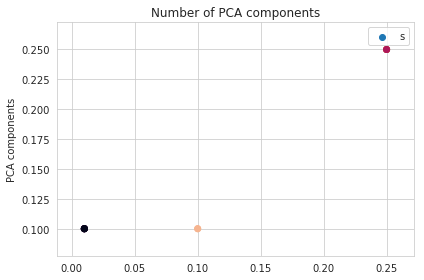

In [36]:
plt.scatter(x=df_best['r'], y=df_best['s'], c=df_best['pca_components'])
plt.title('Number of PCA components')
plt.ylabel('PCA components')
plt.legend()
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_pca_components.png')

Text(0.5,1,'MCC score distribution for different r and s parameters for validation set')

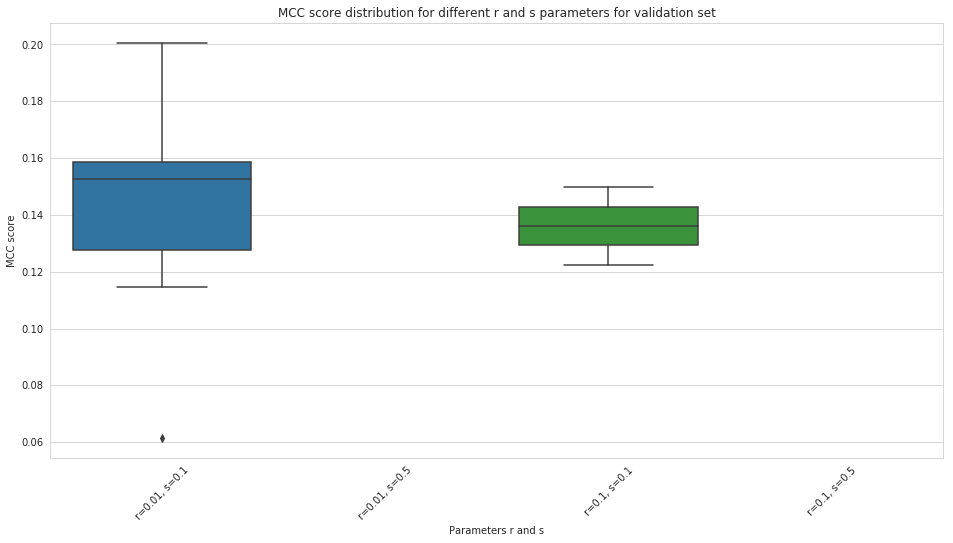

In [37]:
r_s_dict = OrderedDict()
r_parameters = [0.01, 0.1]
s_parameters = [0.1, 0.5]
for r in r_parameters:
    for s in s_parameters:
        r_s_dict['r={}, s={}'.format(r, s)] = df_best[df_best['r'] == r][df_best['s'] == s][
            'matthews_lstm'].values

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=list(r_s_dict.values()))
plt.ylabel('MCC score')
plt.xlabel('Parameters r and s')
_ = ax.set_xticklabels(list(r_s_dict.keys()), rotation=45)
plt.title('MCC score distribution for different r and s parameters for validation set')

## Comparision with QUE+LOG

In [38]:
df_best['diff_test_matthews'] = df_best['test_matthews_lstm'] - df_best['test_matthews_log']
df_best['diff_train_matthews'] = df_best['train_matthews_lstm'] - df_best['train_matthews_log']
df_best['diff_matthews'] = df_best['matthews_lstm'] - df_best['matthews_log']
df_best['diff_test_roc_auc'] = df_best['test_roc_auc_lstm'] - df_best['test_roc_auc_log']
df_best['diff_train_roc_auc'] = df_best['train_roc_auc_lstm'] - df_best['train_roc_auc_log']
df_best['diff_roc_auc'] = df_best['roc_auc_lstm'] - df_best['roc_auc_log']

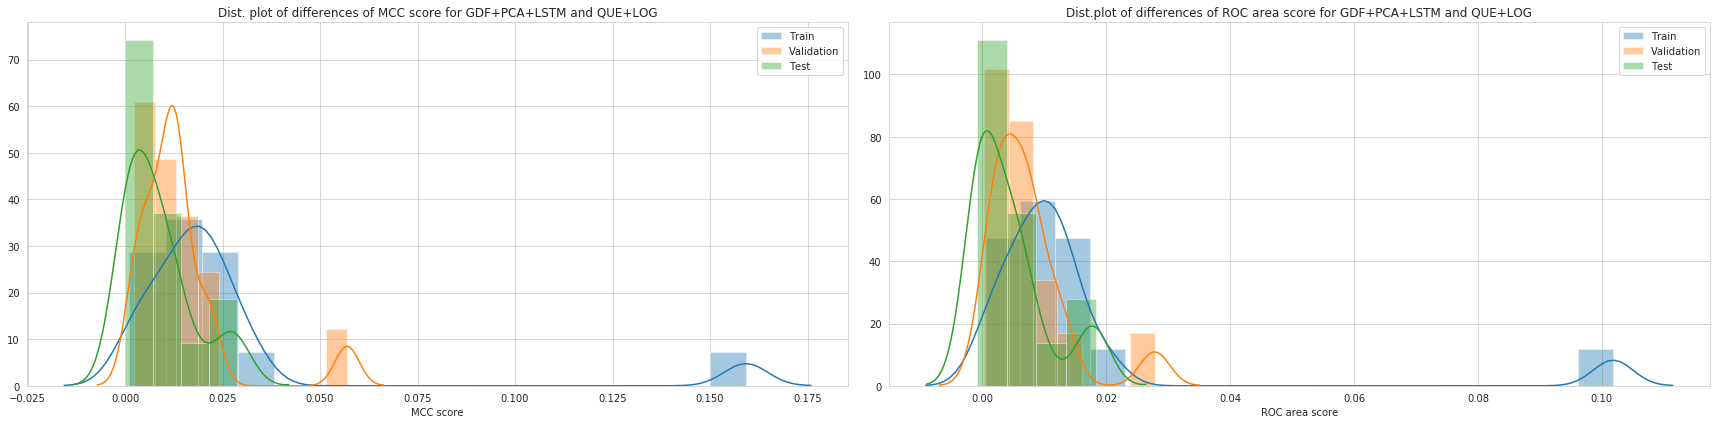

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
sns.distplot(df_best['diff_train_matthews'], label='Train', ax=ax1)
sns.distplot(df_best['diff_matthews'], label='Validation', ax=ax1)
sns.distplot(df_best['diff_test_matthews'], label='Test', ax=ax1)
ax1.set_title('Dist. plot of differences of MCC score for GDF+PCA+LSTM and QUE+LOG')
ax1.set_xlabel('MCC score')
ax1.legend(['Train', 'Validation', 'Test'])

sns.distplot(df_best['diff_train_roc_auc'], label='Train', ax=ax2)
sns.distplot(df_best['diff_roc_auc'], label='Validation', ax=ax2)
sns.distplot(df_best['diff_test_roc_auc'], label='Test', ax=ax2)
ax2.set_title('Dist.plot of differences of ROC area score for GDF+PCA+LSTM and QUE+LOG')
ax2.legend(['Train', 'Validation', 'Test'])
ax2.set_xlabel('ROC area score')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_and_que_log_score_diff.png')

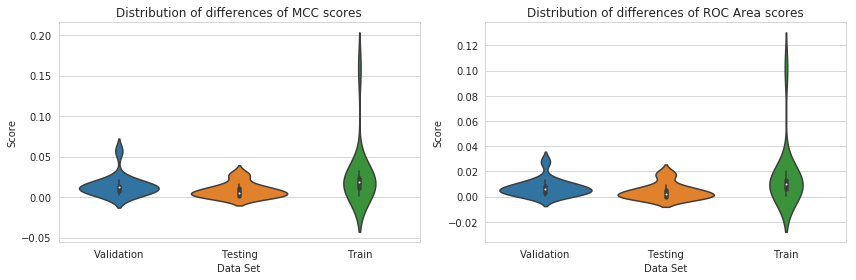

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'diff_matthews', 'diff_roc_auc', 
           'diff_test_matthews', 'diff_test_roc_auc', 'diff_train_matthews', 'diff_train_roc_auc']

df = df_best[columns].copy()
df.rename(columns={
    'diff_matthews': 'Validation', 'diff_test_matthews': 'Testing', 'diff_train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'diff_roc_auc', 'diff_test_roc_auc', 'diff_train_roc_auc'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of differences of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(
    columns={'diff_roc_auc': 'Validation', 'diff_test_roc_auc': 'Testing', 'diff_train_roc_auc': 'Train'}, 
    inplace=True)
df = df.melt(['stock', 'diff_matthews', 'diff_test_matthews', 'diff_train_matthews'])

ax2.set_title('Distribution of differences of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_and_que_log_violin_score_diff.png')

In [41]:
bad = df_best[df_best['test_matthews_lstm'] < df_best['test_matthews_log']]['stock'].values

In [42]:
df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']][df_best['stock'].isin(bad)]

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
stock,,,,,,


In [43]:
df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']][df_best['stock'].isin(bad)].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.026171,0.014152,0.008577,0.015511,0.007316,0.004434
std,0.037857,0.013118,0.008983,0.024429,0.006748,0.006192
min,0.001089,0.002216,0.000033,0.000546,0.000354,-0.000865
25%,0.011293,0.007213,0.001497,0.006321,0.002979,-0.000258
50%,0.018565,0.012209,0.005229,0.010137,0.005822,0.002309
75%,0.023473,0.014037,0.011135,0.013352,0.008298,0.005661
max,0.159213,0.056952,0.028760,0.101806,0.027829,0.018325


In [45]:
print(df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  diff\_train\_matthews &  diff\_matthews &  diff\_test\_matthews &  diff\_train\_roc\_auc &  diff\_roc\_auc &  diff\_test\_roc\_auc \\
\midrule
count &            15.000000 &      15.000000 &           15.000000 &           15.000000 &     15.000000 &          15.000000 \\
mean  &             0.026171 &       0.014152 &            0.008577 &            0.015511 &      0.007316 &           0.004434 \\
std   &             0.037857 &       0.013118 &            0.008983 &            0.024429 &      0.006748 &           0.006192 \\
min   &             0.001089 &       0.002216 &            0.000033 &            0.000546 &      0.000354 &          -0.000865 \\
25\%   &             0.011293 &       0.007213 &            0.001497 &            0.006321 &      0.002979 &          -0.000258 \\
50\%   &             0.018565 &       0.012209 &            0.005229 &            0.010137 &      0.005822 &           0.002309 \\
75\%   &             0.023473 &    

In [46]:
print(df_best[df_best['test_roc_auc_lstm'] < df_best['test_roc_auc_log']]['stock'].values)

[3879 4320 1431 3459 9058]


In [47]:
print(list(df_best[df_best['test_matthews_lstm'] < df_best['test_matthews_log']]['stock'].values))

[]


In [48]:
columns = ['stock'] + [c for c in df_best.columns if 'matthews' in c]
df_best[columns + ['arch']]

for i, row in df_best.iterrows():
    
    m = model_from_json(row['arch'])

    from keras.utils import plot_model
    st = row['stock']
    r = row['r']
    s = row['s']
    if if_should_savefig:
        plot_model(m, show_layer_names=True, show_shapes=True, to_file=f'plot_model/model_{st}_r{r}_s{s}.png')

In [28]:
df_best[['r', 's', 'matthews_lstm', 'test_matthews_lstm', 'test_matthews_log', 'stock', 'filename']]

,r,s,matthews_lstm,test_matthews_lstm,test_matthews_log,stock,filename
stock,,,,,,,
2748,0.01,0.10,0.200579,0.146445,0.134270,2748,res_gru_pca_n_one_layer_step16_2748_len24000_r...
3879,0.01,0.10,0.158942,0.120586,0.120553,3879,res_gru_pca_n_one_layer_step4_3879_len24000_r0...
9761,0.01,0.10,0.158637,0.111831,0.107514,9761,res_gru_pca_n_one_layer_step16_9761_len24000_r...
4851,0.01,0.10,0.155013,0.164520,0.138680,4851,res_gru_pca_n_one_layer_step16_4851_len24000_r...
10470,0.01,0.10,0.150017,0.137040,0.126946,10470,res_gru_pca_n_one_layer_10470_len24000_r0.01_s...
4320,0.10,0.10,0.149794,0.131705,0.133149,4320,res_gru_pca_n_one_layer_step16_4320_len24000_r...
2730,0.25,0.25,0.142332,0.166390,0.150420,2730,res_gru_pca_n_one_layer_step4_2730_len24000_r0...
4799,0.10,0.50,0.139978,0.122519,0.124435,4799,res_gru_pca_n_one_layer_step16_4799_len24000_r...
1431,0.25,0.25,0.136941,0.123672,0.123012,1431,res_gru_pca_n_one_layer_step16_1431_len24000_r...
